<a href="https://colab.research.google.com/github/Joeychen80627/Integrated-Energy-System-Multi-Load-Prediction/blob/main/Integrated_Energy_System_Multi_Load_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

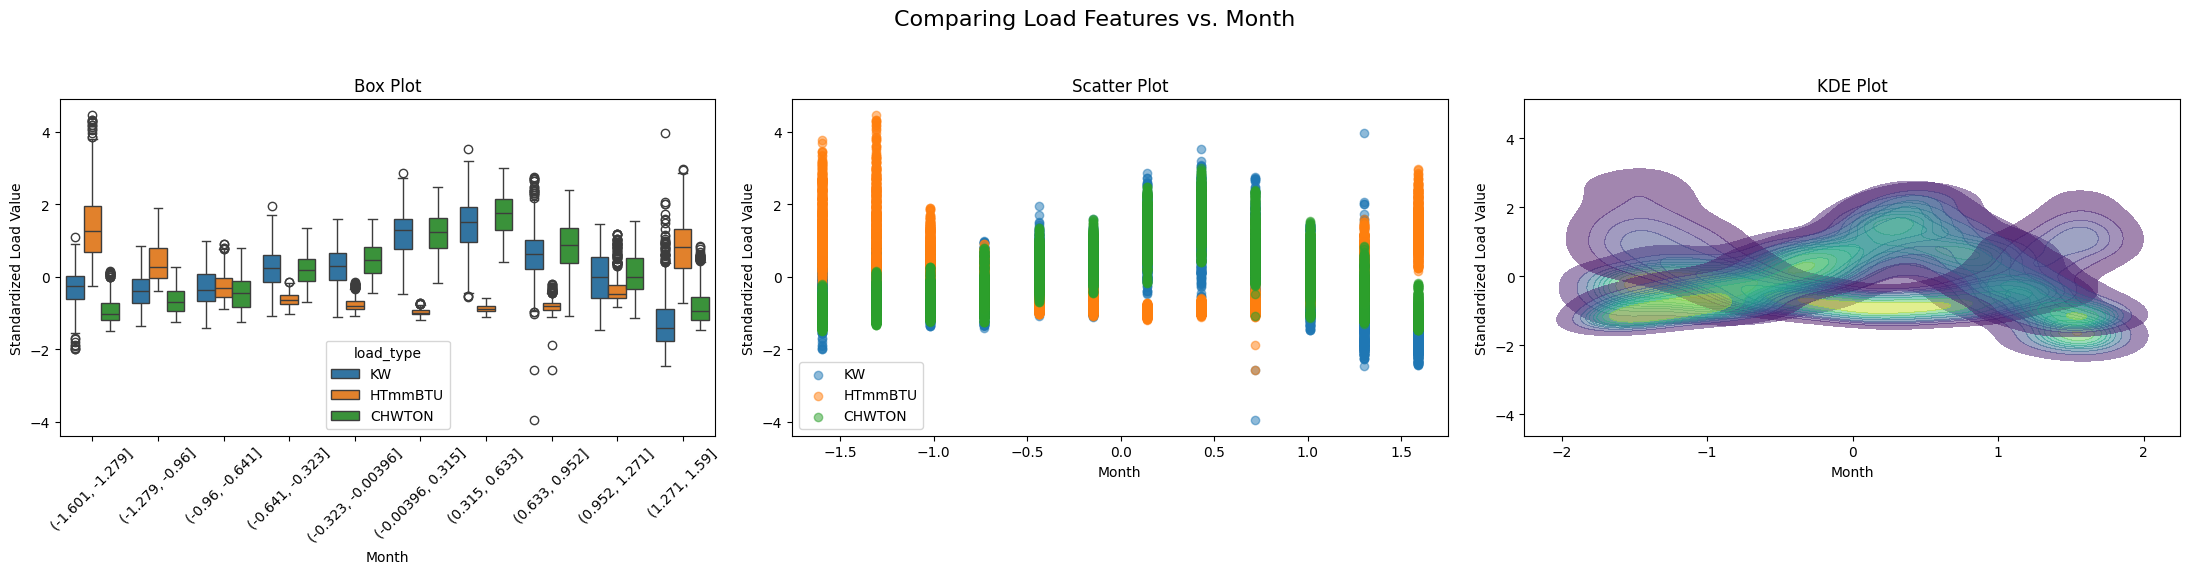

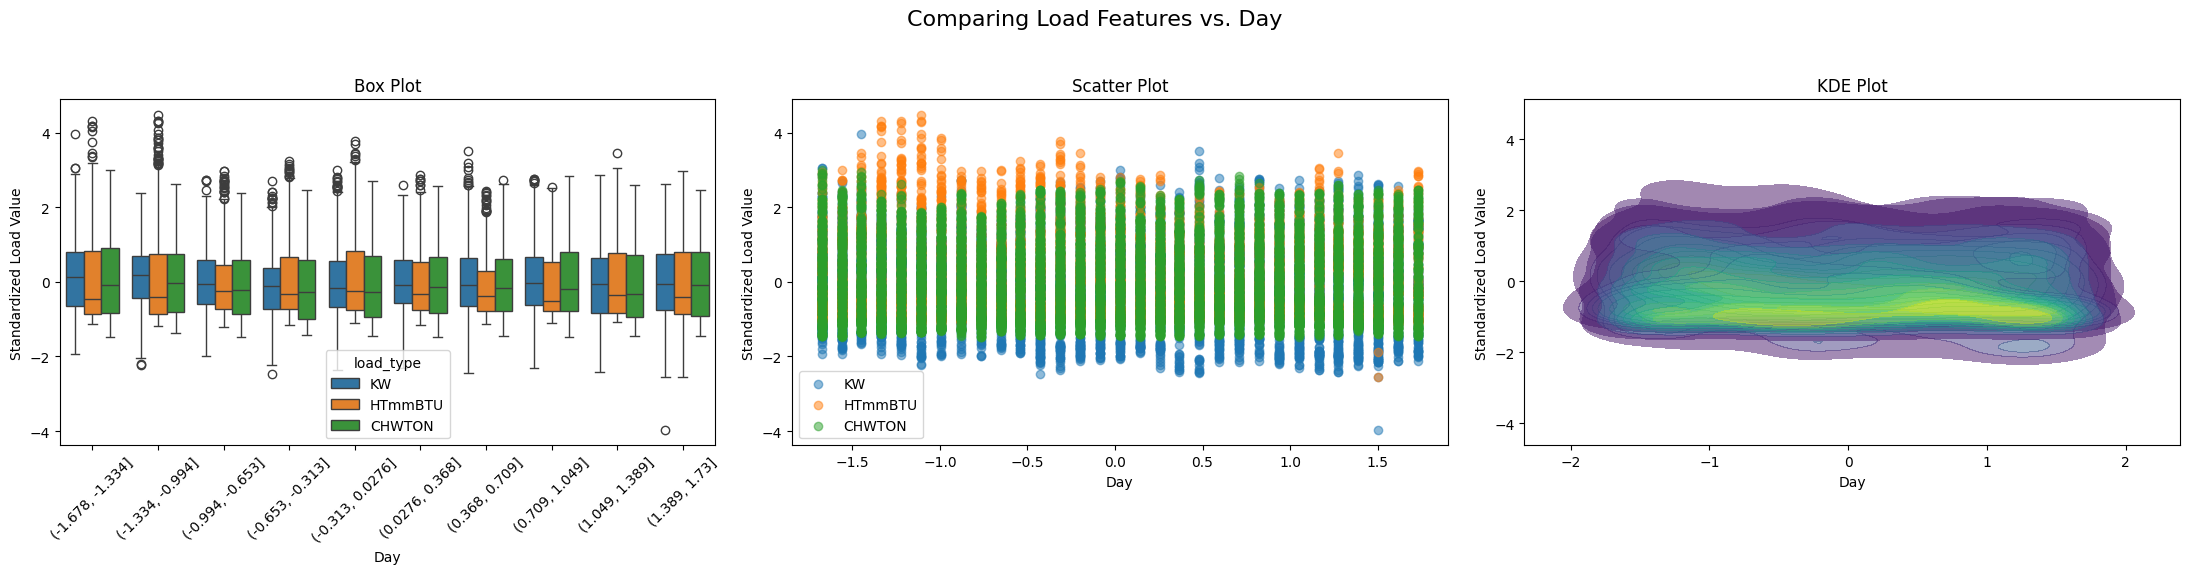

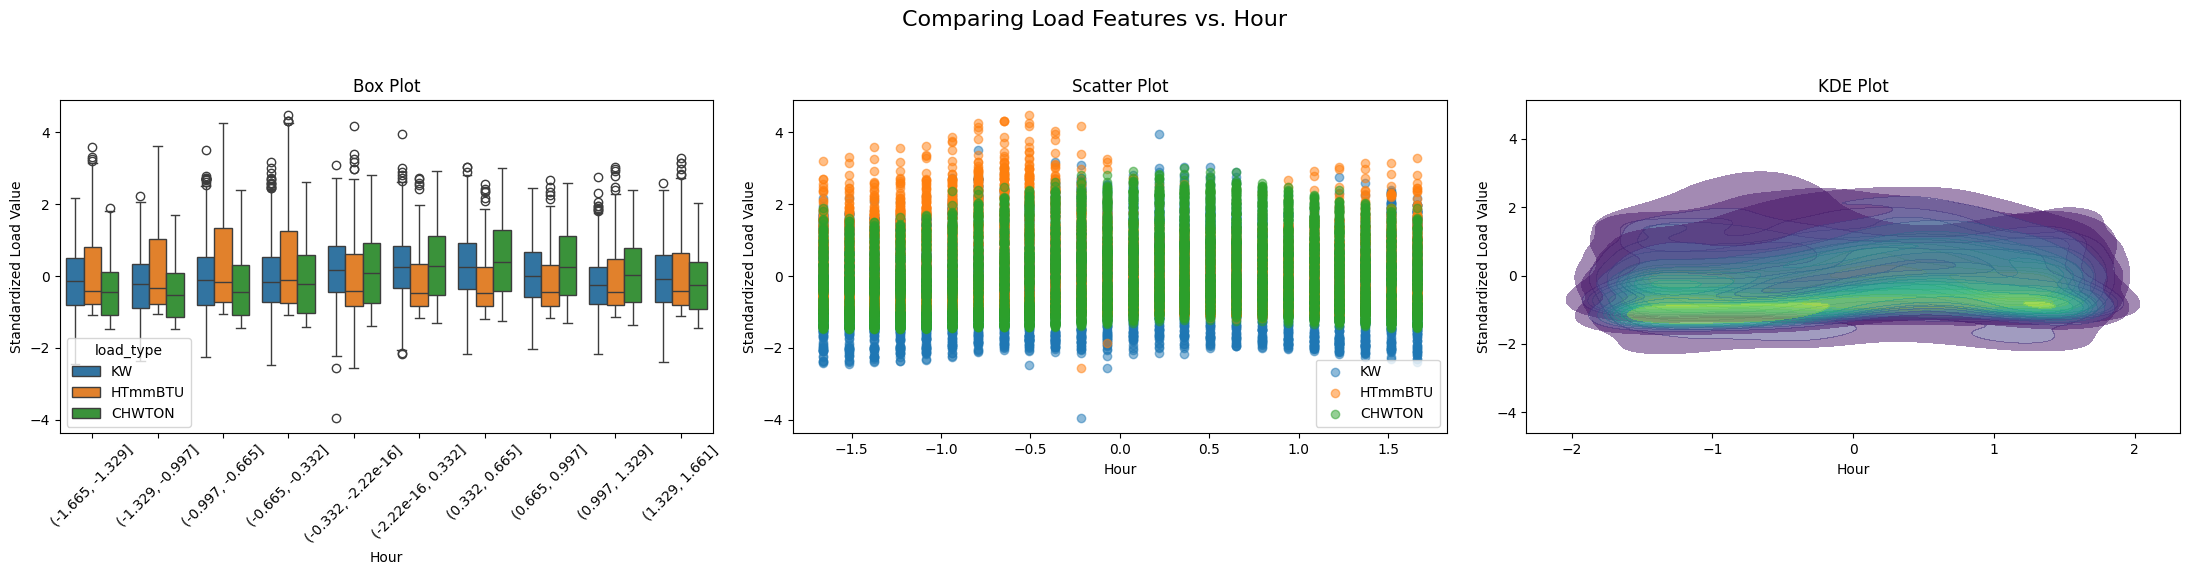

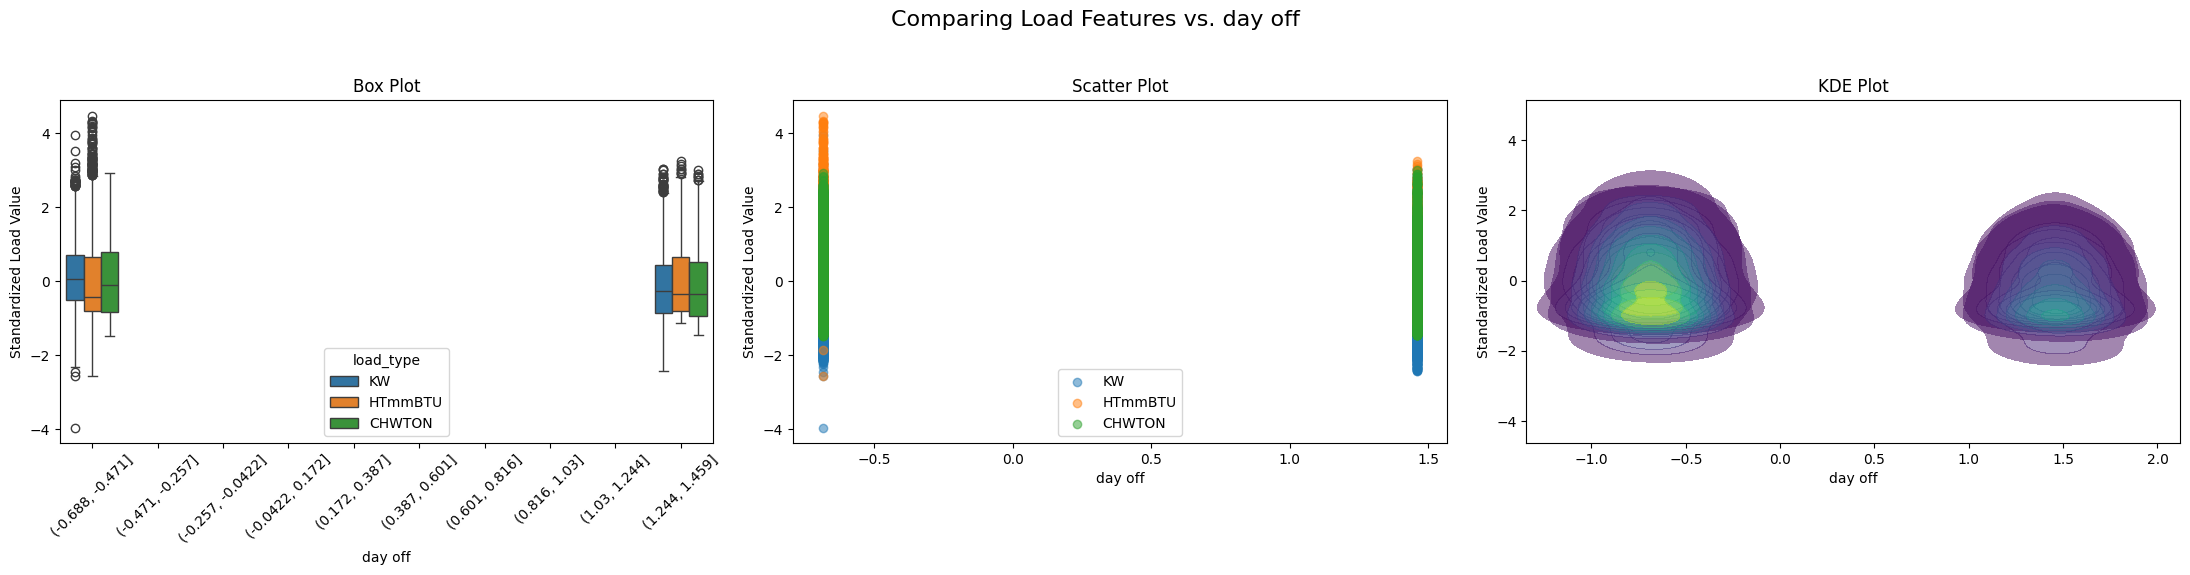

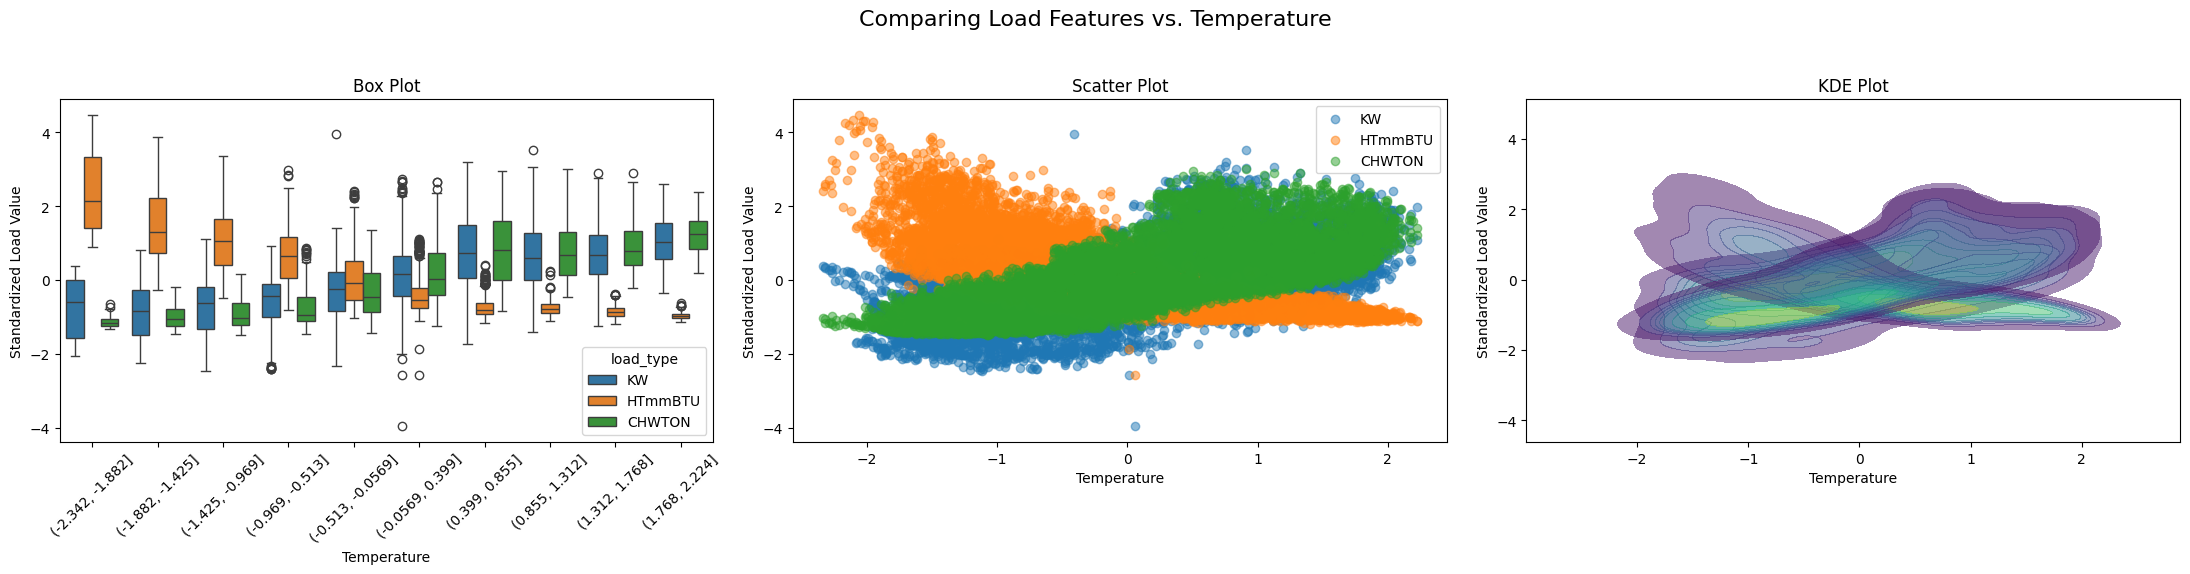

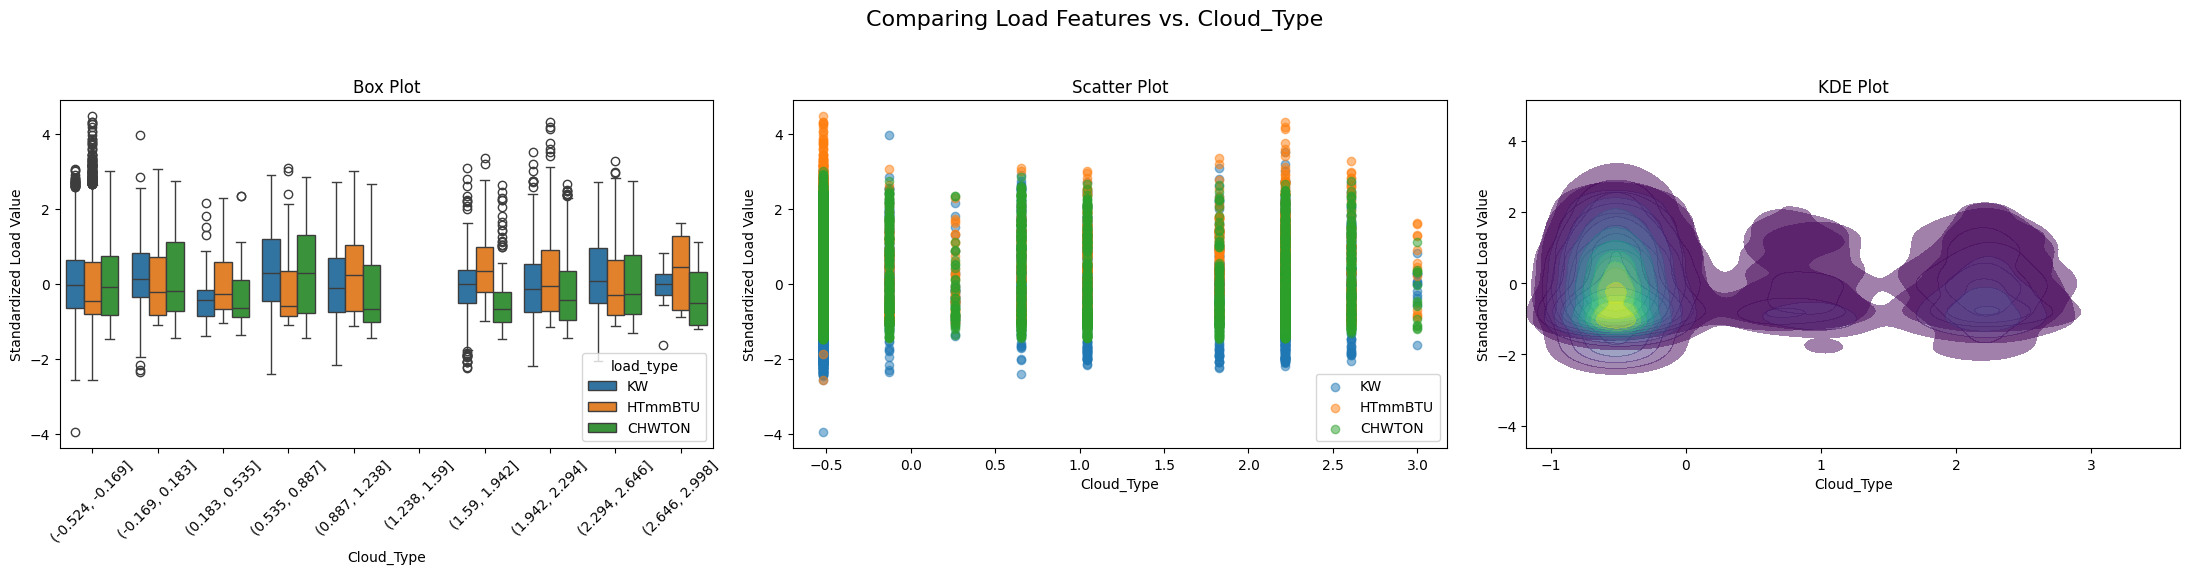

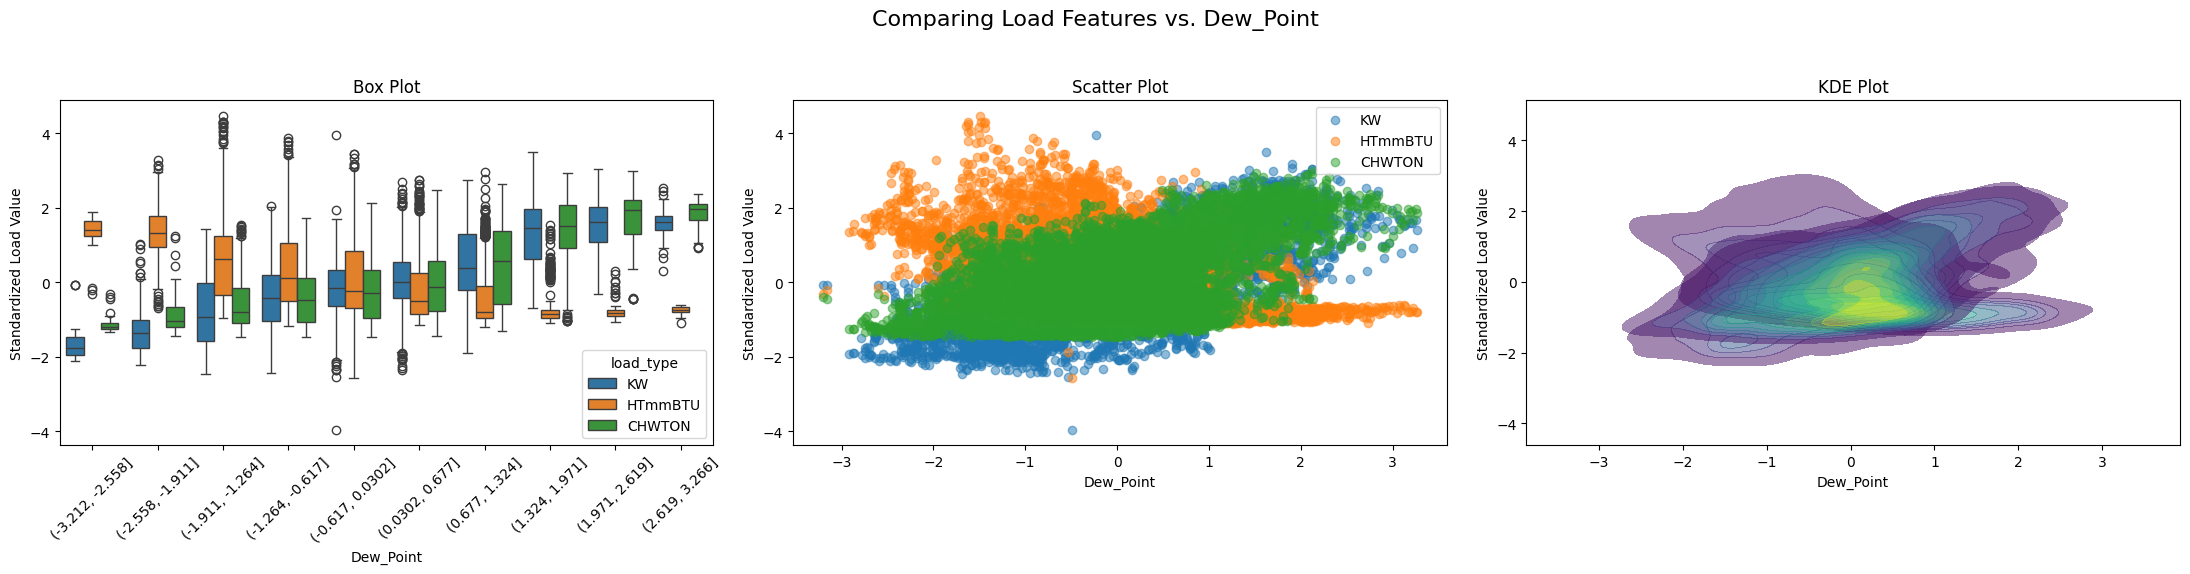

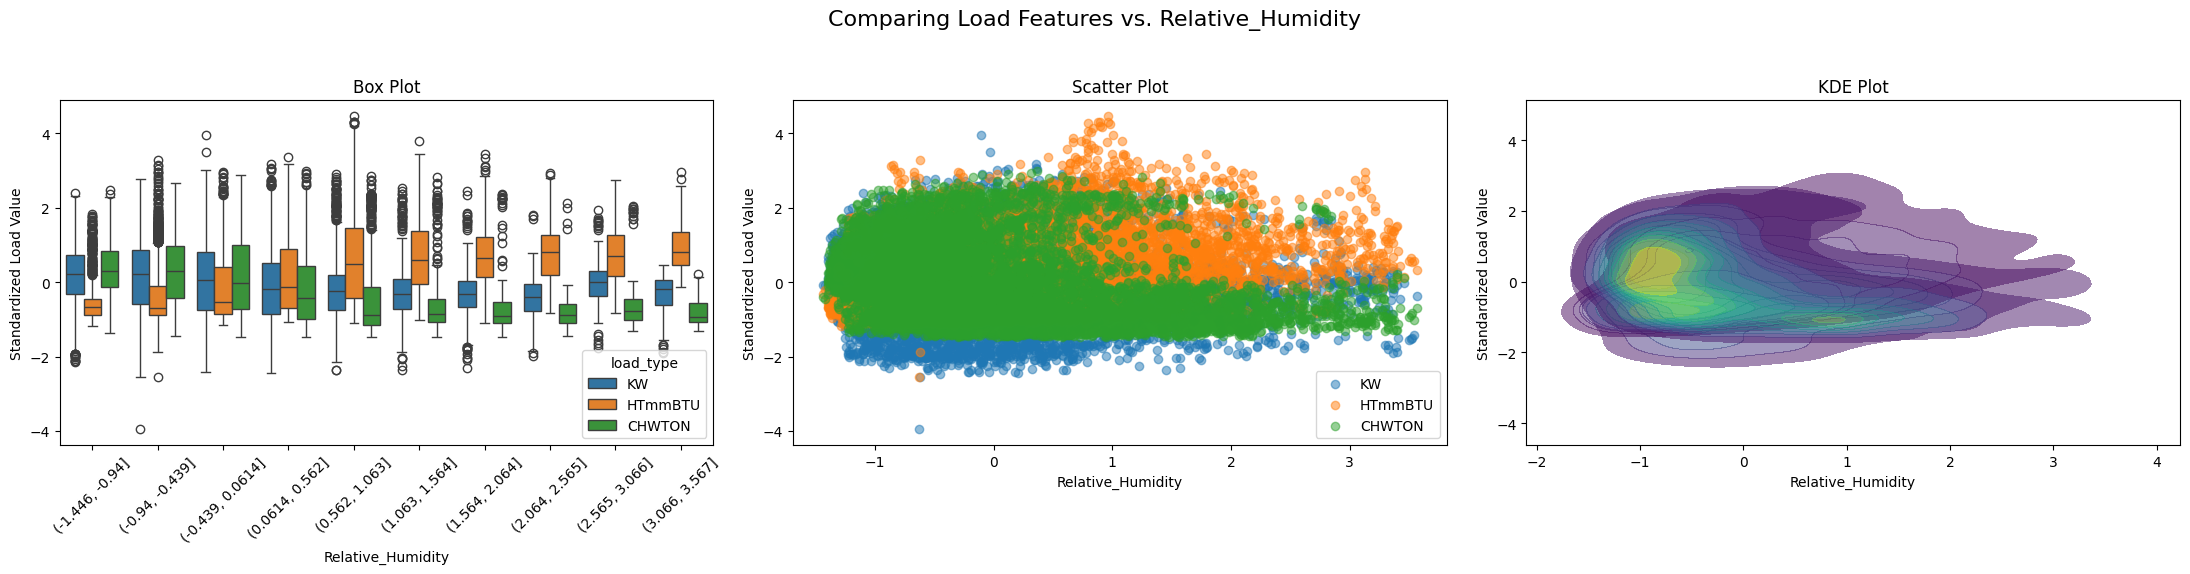

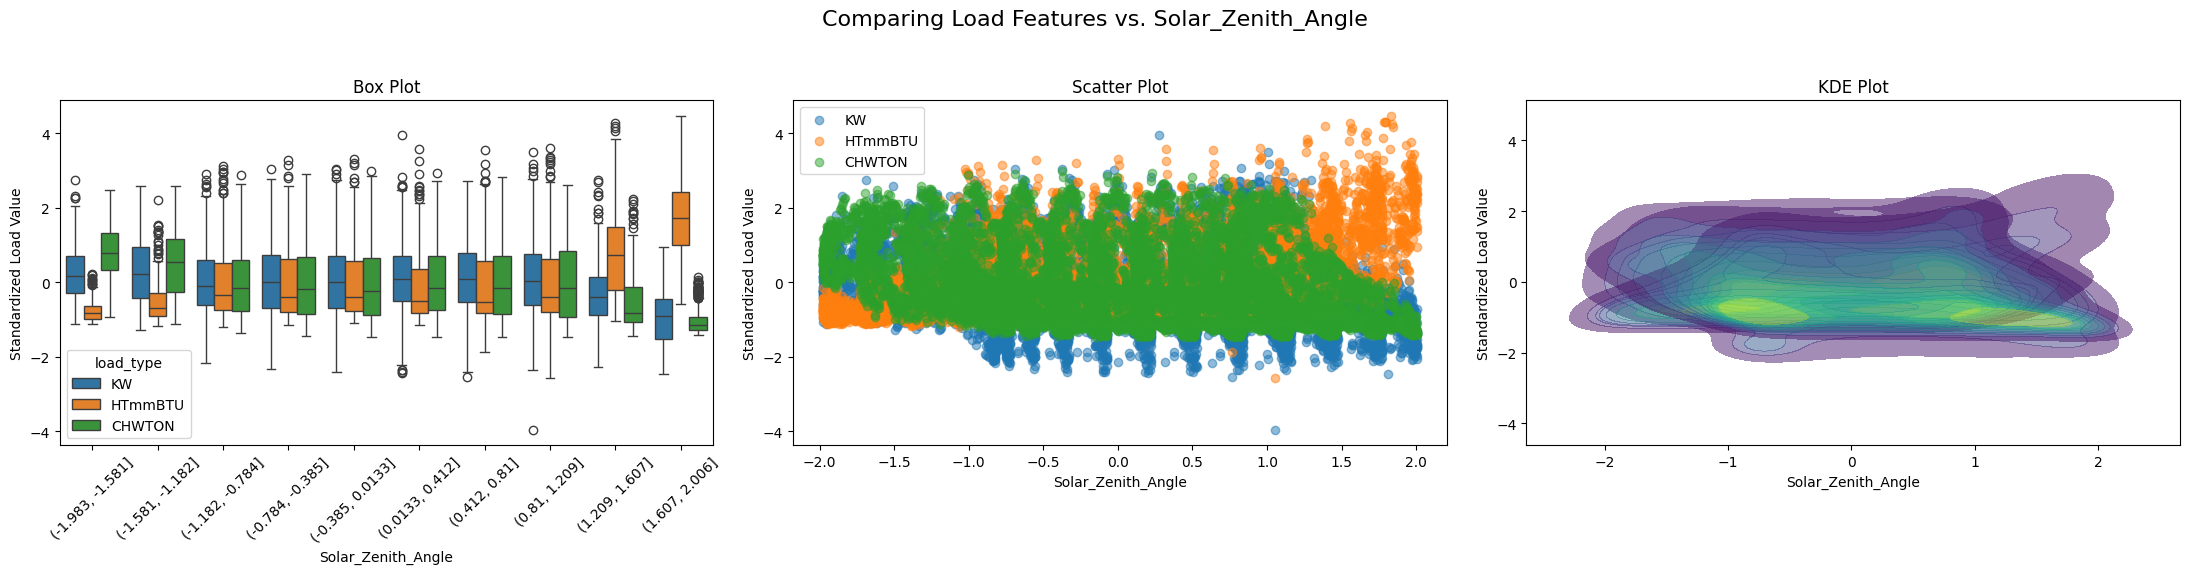

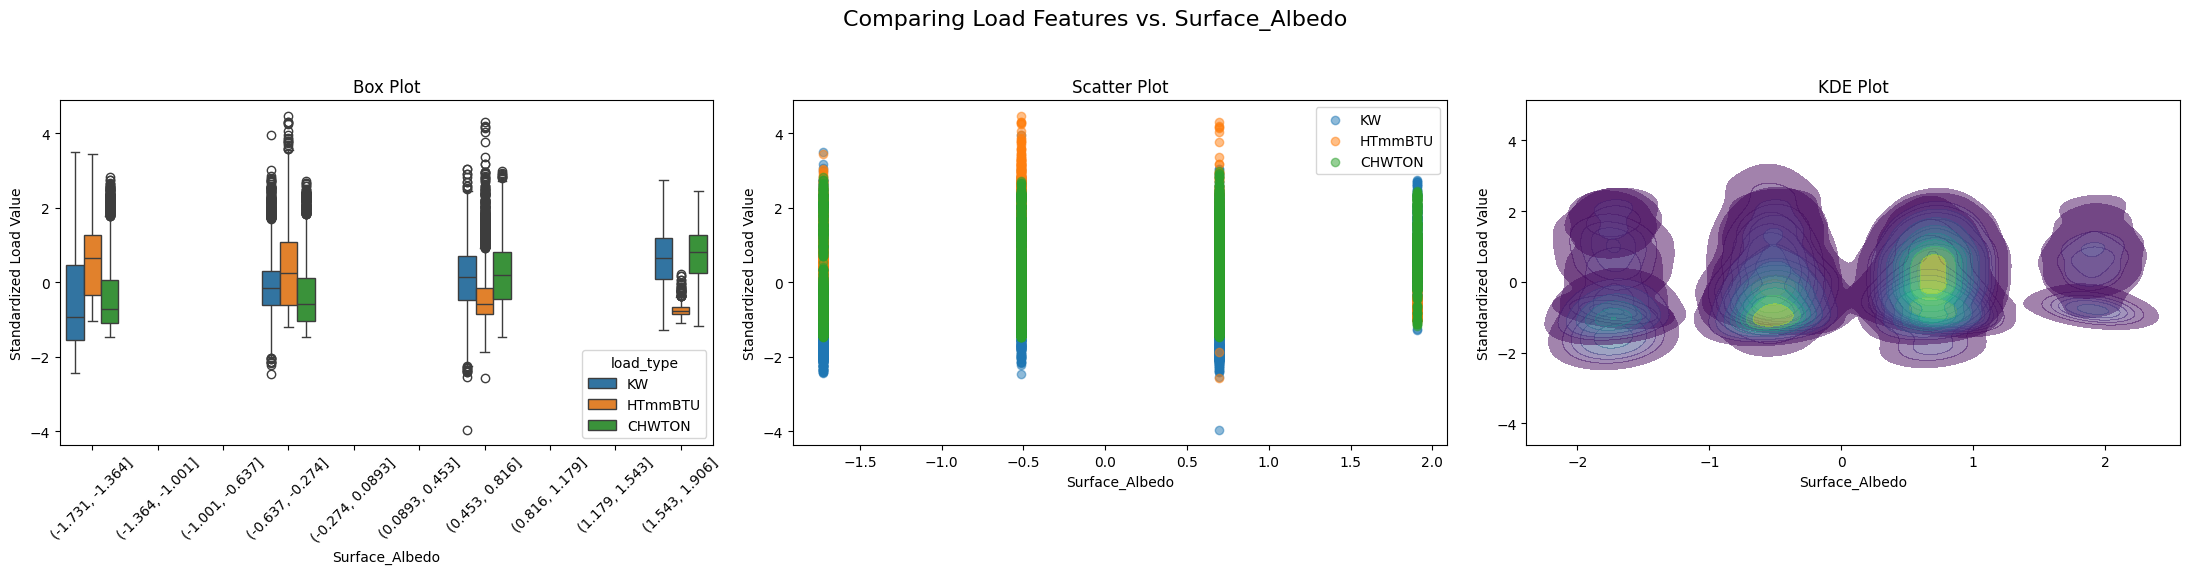

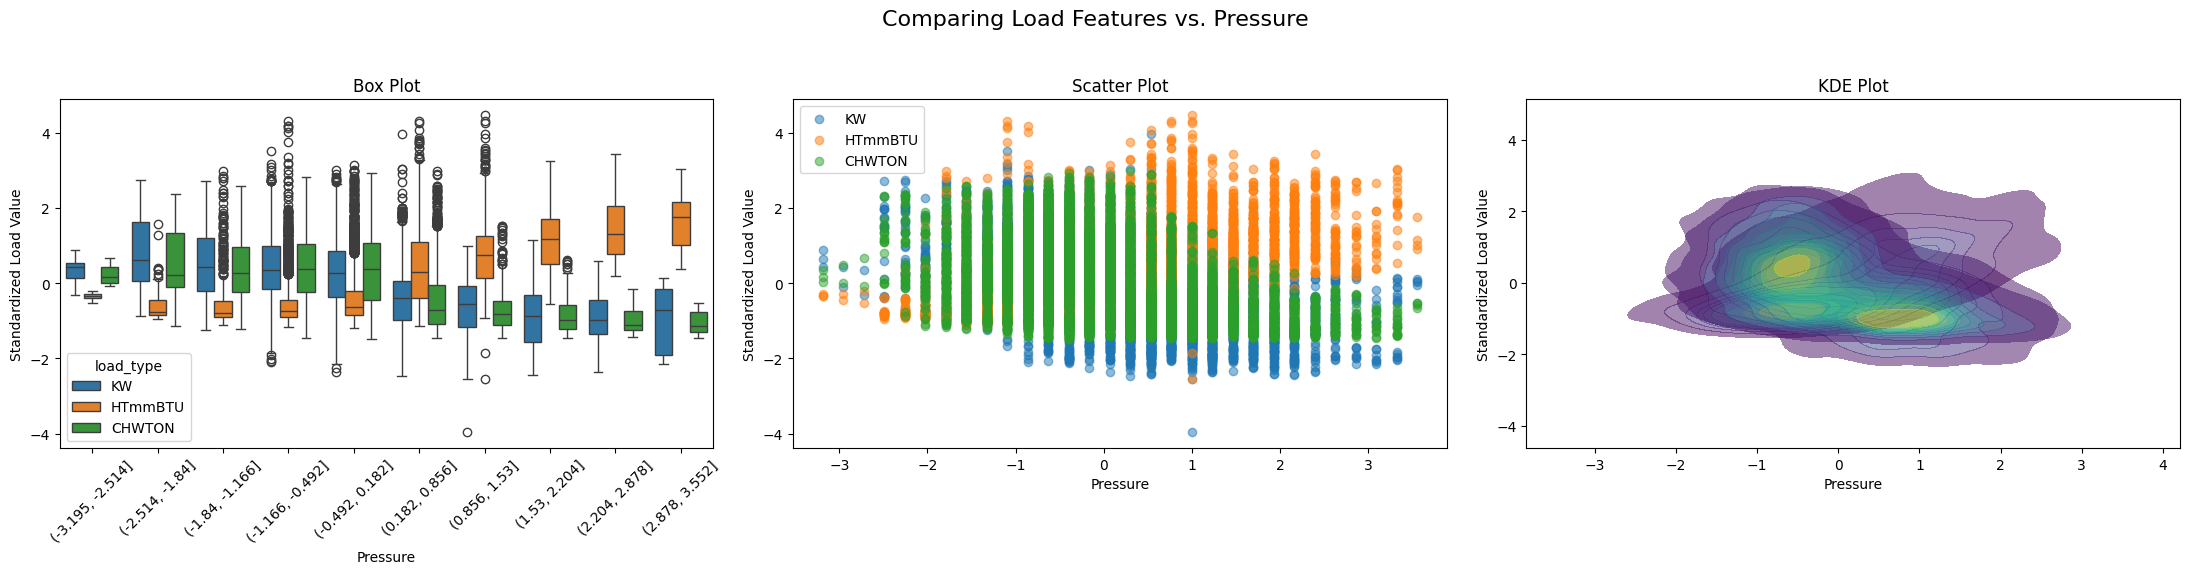

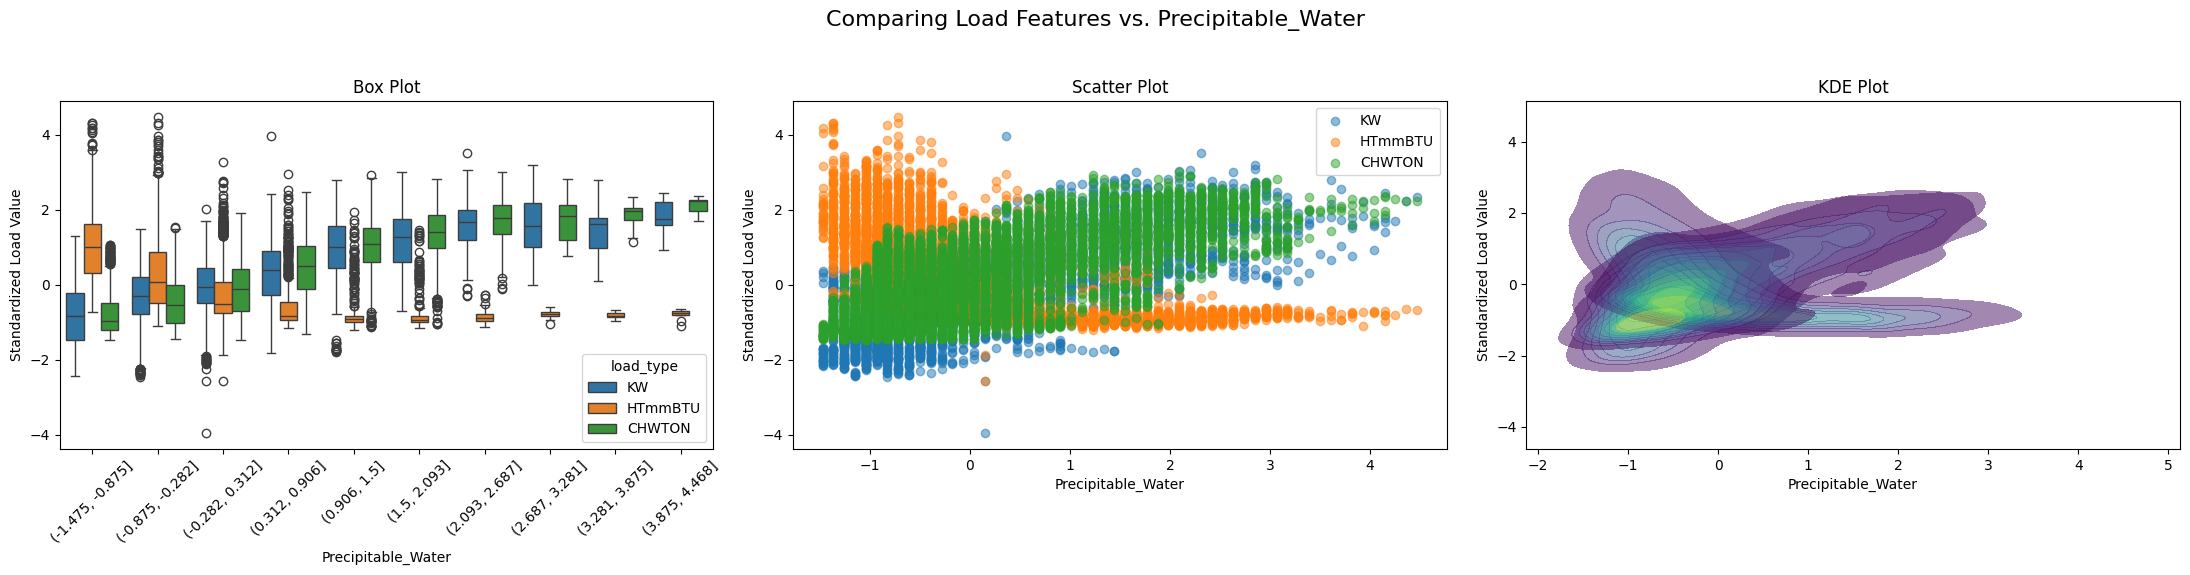

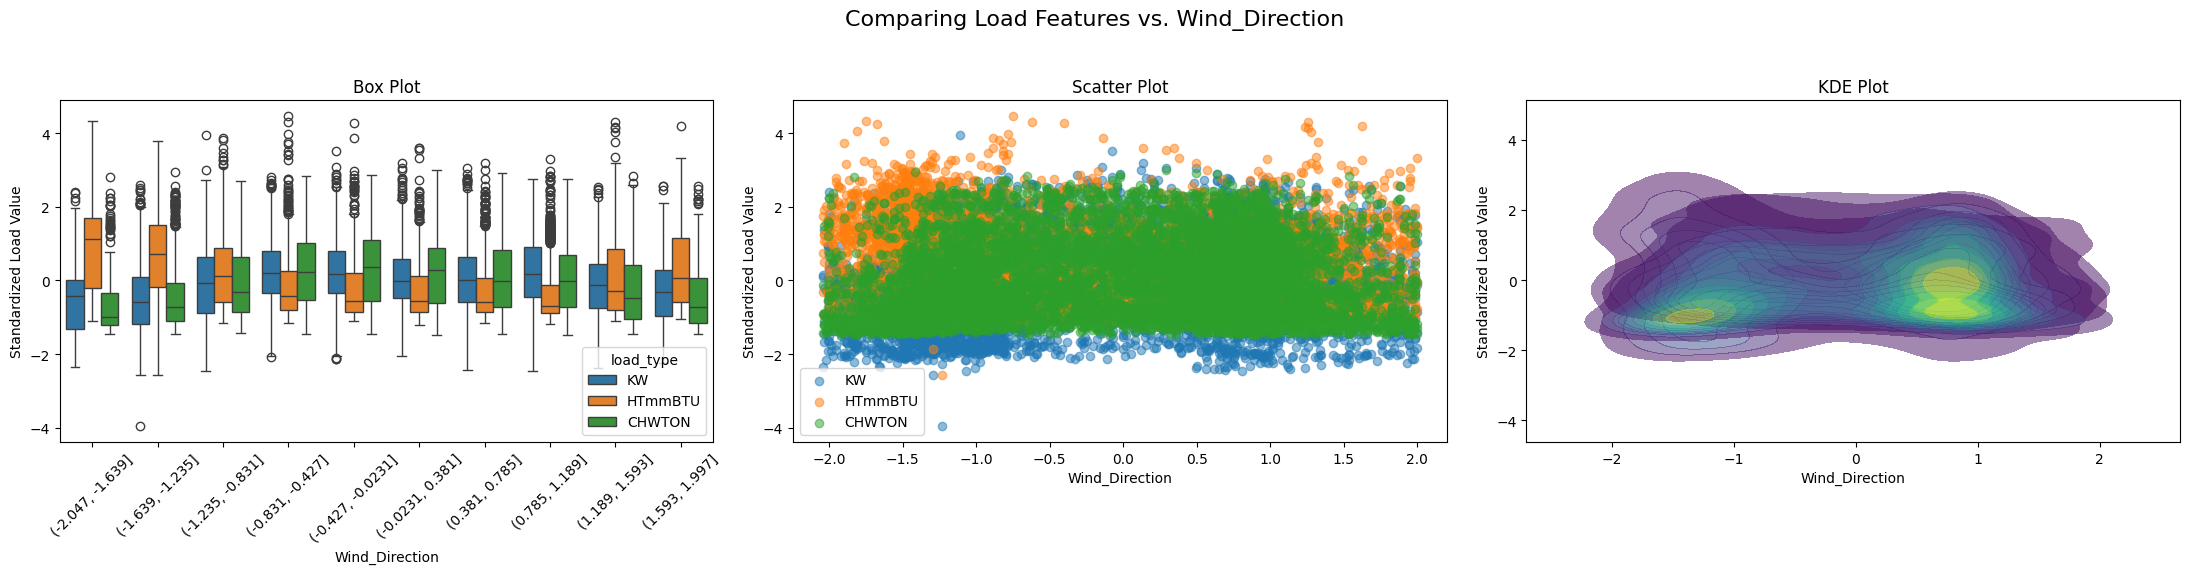

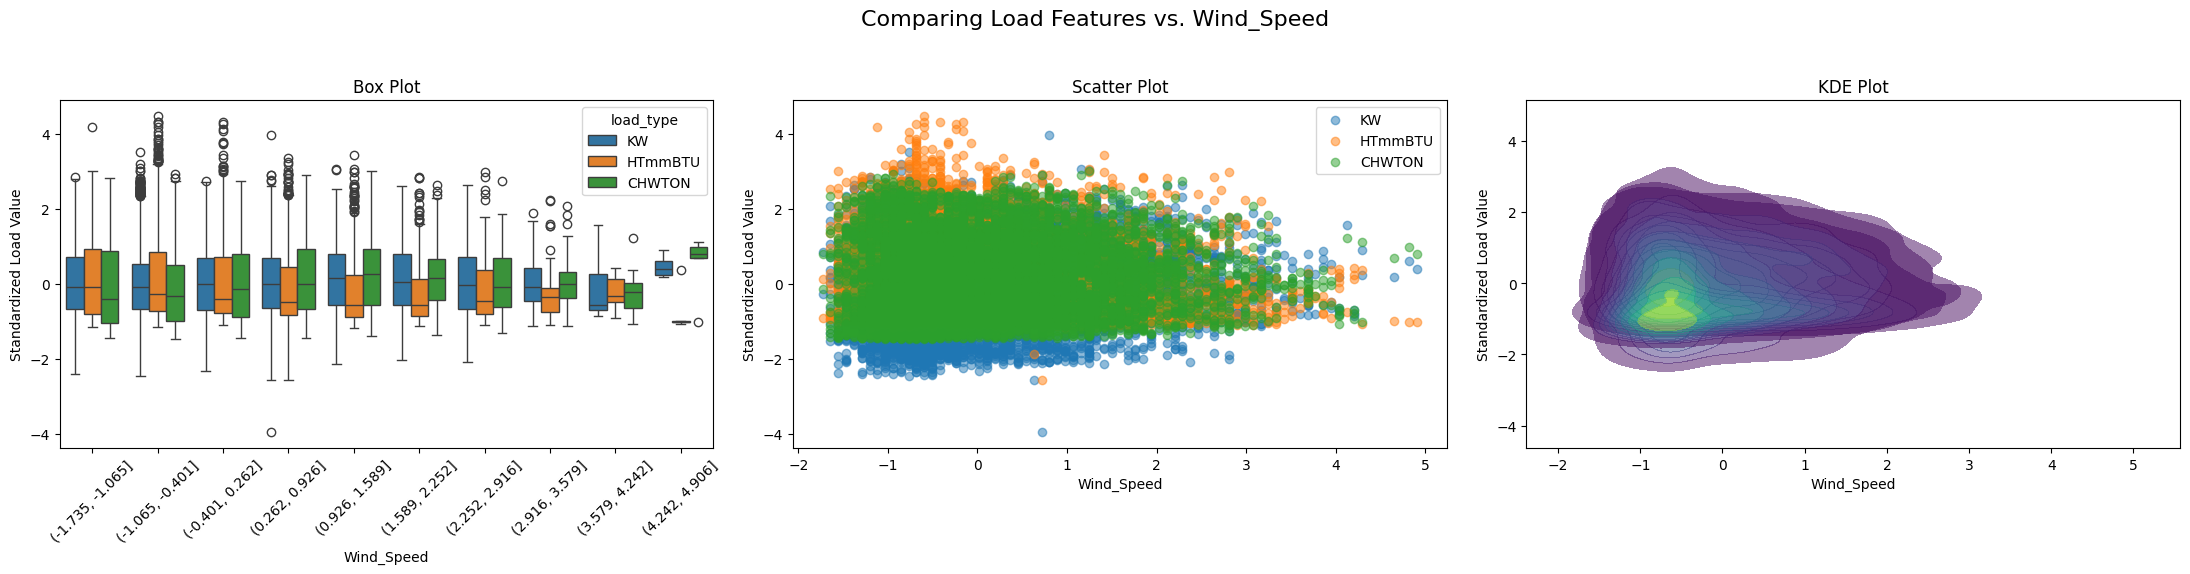

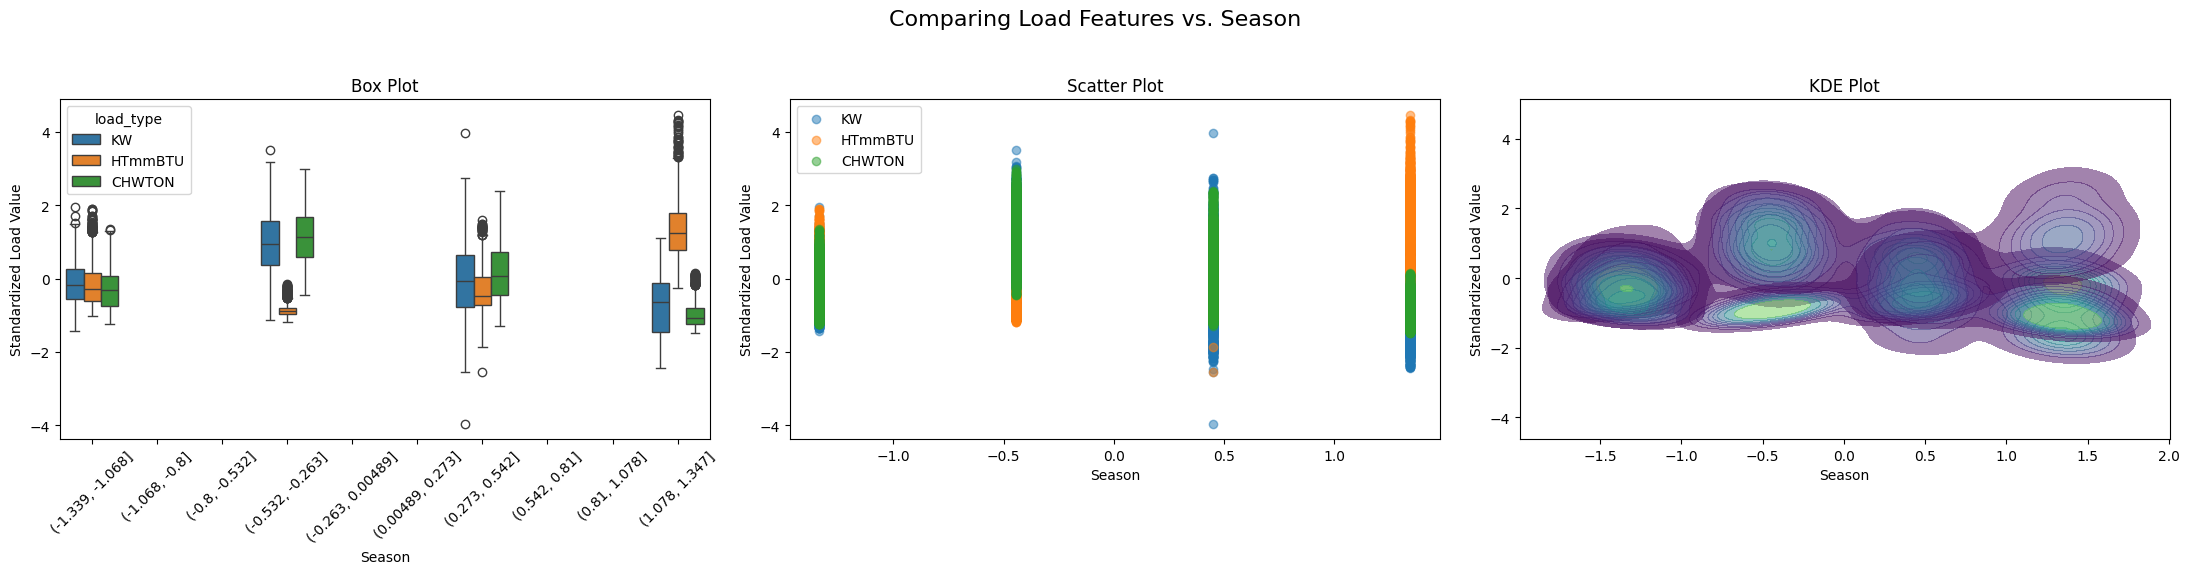

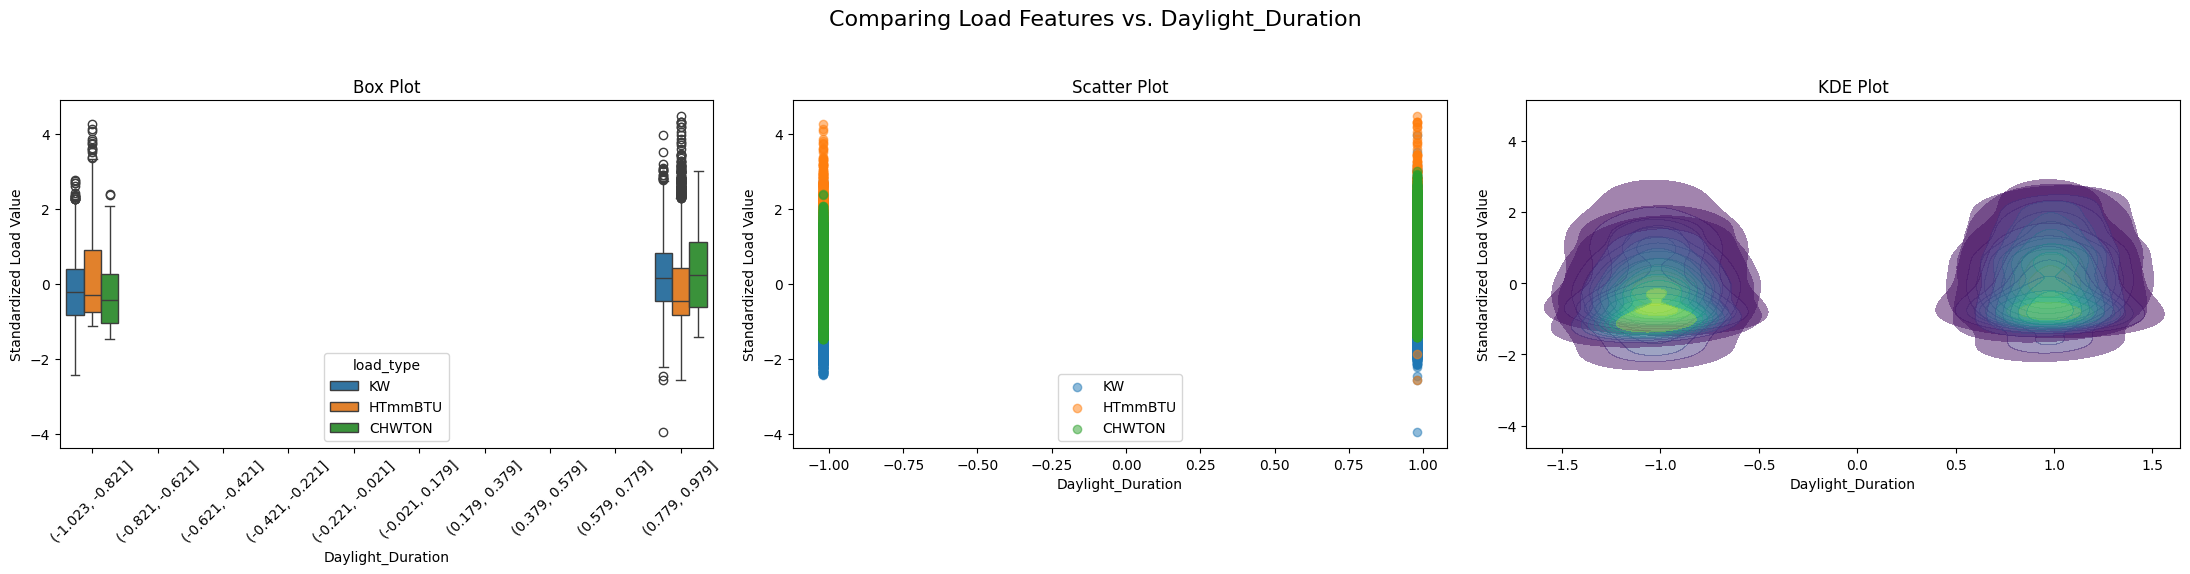

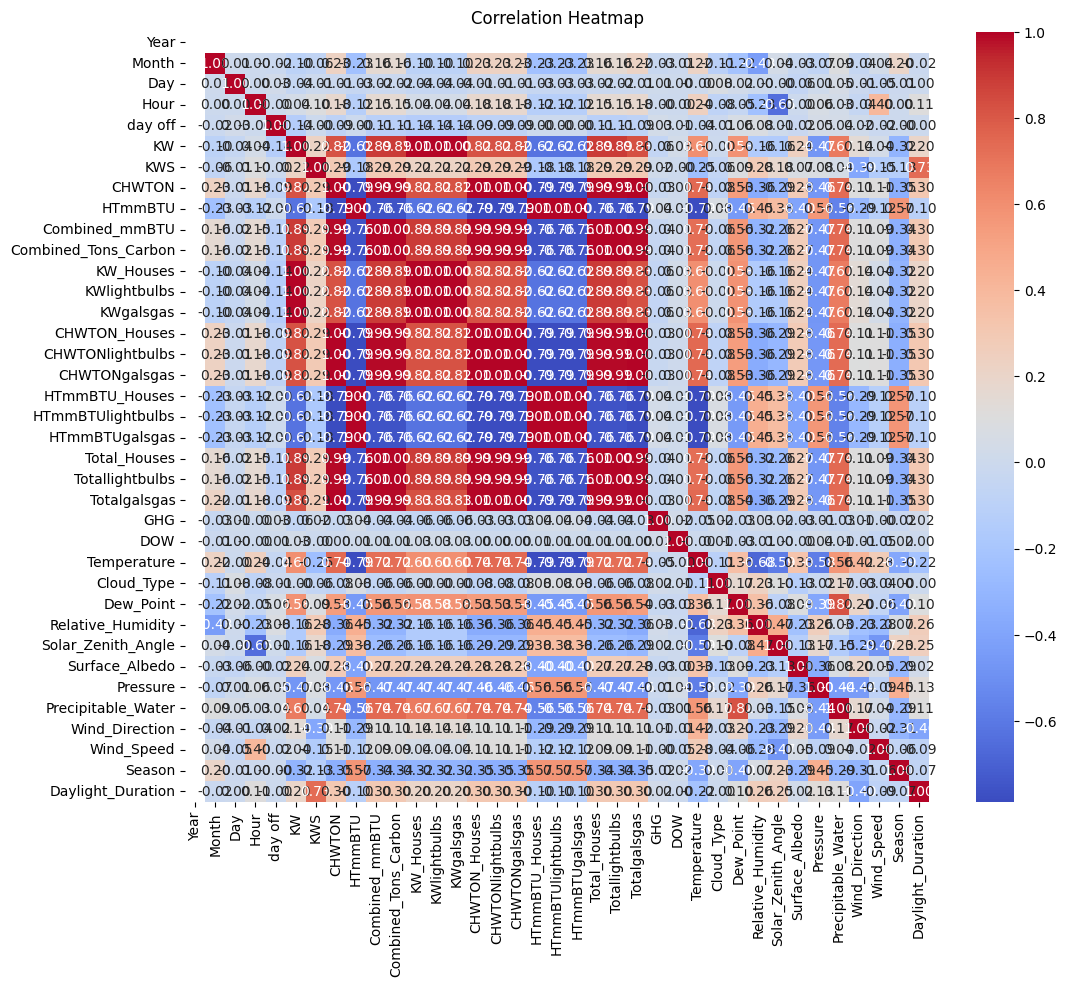

In [5]:
#EDA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import UndefinedMetricWarning

# Ignore UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


# 1. Load Dataset and Preprocess
file_path = "/content/drive/MyDrive/CU/Machine Learning: Theory & Hands-On Practice with Python/energy_data.xlsx"
df = pd.read_excel(file_path)

# Define a function to assign seasons based on month
def assign_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

# Add a 'Season' column
df['Season'] = df['Month'].apply(assign_season)

# Add sunrise and sunset times for each month using a dictionary mapping
sunrise_sunset = {
    1:  (7.00, 18.00), 2:  (6.75, 18.25), 3:  (6.25, 18.00),
    4:  (6.00, 19.00), 5:  (5.75, 19.25), 6:  (5.50, 19.75),
    7:  (5.50, 19.75), 8:  (5.75, 19.25), 9:  (6.25, 18.00),
    10: (6.50, 17.75), 11: (6.75, 17.50), 12: (7.00, 18.00)
}
df['Sunrise'] = df['Month'].map(lambda x: sunrise_sunset[x][0])
df['Sunset'] = df['Month'].map(lambda x: sunrise_sunset[x][1])

# Create a binary "Daylight_Duration" column:
# 1 if the Hour is between sunrise and sunset, else 0
df['Daylight_Duration'] = np.where((df['Hour'] >= df['Sunrise']) & (df['Hour'] < df['Sunset']), 1, 0)

# Remove the temporary 'Sunrise' and 'Sunset' columns
df.drop(columns=['Sunrise', 'Sunset'], inplace=True)


# 2. Define Feature Types and Remove Redundant Features
# (This dictionary is for reference and later filtering)
numeric_features = {
    'Year': 'numeric', 'Month': 'numeric', 'Day': 'numeric', 'Hour': 'numeric',
    'KW': 'numeric', 'KWS': 'numeric', 'CHWTON': 'numeric', 'HTmmBTU': 'numeric',
    'Combined_mmBTU': 'numeric', 'Combined_Tons_Carbon': 'numeric',
    'KW_Houses': 'numeric', 'KWlightbulbs': 'numeric', 'KWgalsgas': 'numeric',
    'CHWTON_Houses': 'numeric', 'CHWTONlightbulbs': 'numeric', 'CHWTONgalsgas': 'numeric',
    'HTmmBTU_Houses': 'numeric', 'HTmmBTUlightbulbs': 'numeric', 'HTmmBTUgalsgas': 'numeric',
    'Total_Houses': 'numeric', 'Totallightbulbs': 'numeric', 'Totalgalsgas': 'numeric',
    'GHG': 'numeric', 'Temperature': 'numeric', 'Dew_Point': 'numeric', 'Relative_Humidity': 'numeric',
    'Solar_Zenith_Angle': 'numeric', 'Surface_Albedo': 'numeric', 'Pressure': 'numeric',
    'Precipitable_Water': 'numeric', 'Wind_Speed': 'numeric'
}
categorical_features = {
    'day off': 'categorical', 'DOW': 'categorical', 'Cloud_Type': 'categorical', 'Wind_Direction': 'categorical',
    'Season': 'categorical', 'Daylight_Duration': 'categorical'
}

# Remove redundant features based on prior analysis
redundant_features = [
    'KW_Houses', 'KWlightbulbs', 'KWgalsgas',
    'CHWTON_Houses', 'CHWTONlightbulbs', 'CHWTONgalsgas',
    'HTmmBTU_Houses', 'HTmmBTUlightbulbs', 'HTmmBTUgalsgas',
    'Totallightbulbs', 'Totalgalsgas', 'KWS', 'Combined_mmBTU',
    'Combined_Tons_Carbon', 'GHG', 'Year', 'DOW', 'Total_Houses'
]
df_clean = df.drop(columns=redundant_features)


# 3. Identify Numeric Columns and Define Predictor/Load Features
# Get list of numeric columns from the cleaned dataframe
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

# Define load features to compare
load_features = ['KW', 'HTmmBTU', 'CHWTON']

# Predictor features are all numeric columns except the load features
predictor_features = [col for col in numeric_cols if col not in load_features]


# 4. Standardize All Numeric Features (Z-score Normalization)
scaler = StandardScaler()
df_clean_std = df_clean.copy()
df_clean_std[numeric_cols] = scaler.fit_transform(df_clean[numeric_cols])


# 5. Visualization: Compare Each Predictor vs. Load Features
for predictor in predictor_features:
    # Create a new figure with 3 subplots: Box, Scatter, and KDE
    fig, axes = plt.subplots(1, 3, figsize=(22, 6))
    fig.suptitle(f"Comparing Load Features vs. {predictor}", fontsize=16)

    #Box Plot
    # Bin the predictor into 10 equal-width bins
    df_temp = df_clean_std[[predictor] + load_features].copy()
    df_temp['bin'] = pd.cut(df_temp[predictor], bins=10)
    # Melt the dataframe for seaborn boxplot
    df_melted = df_temp.melt(id_vars=['bin'], value_vars=load_features,
                             var_name='load_type', value_name='load_value')
    sns.boxplot(x='bin', y='load_value', hue='load_type', data=df_melted, ax=axes[0])
    axes[0].set_title("Box Plot")
    axes[0].set_xlabel(predictor)
    axes[0].set_ylabel("Standardized Load Value")
    axes[0].tick_params(axis='x', rotation=45)

    #Subplot 2: Scatter Plot
    for lf in load_features:
        axes[1].scatter(df_clean_std[predictor], df_clean_std[lf], alpha=0.5, label=lf)
    axes[1].set_title("Scatter Plot")
    axes[1].set_xlabel(predictor)
    axes[1].set_ylabel("Standardized Load Value")
    axes[1].legend()

    # KDE Plot
    for lf in load_features:
        sns.kdeplot(x=df_clean_std[predictor], y=df_clean_std[lf], ax=axes[2],
                    cmap="viridis", fill=True, thresh=0.05, alpha=0.5, label=lf)
    axes[2].set_title("KDE Plot")
    axes[2].set_xlabel(predictor)
    axes[2].set_ylabel("Standardized Load Value")
    handles, labels = axes[2].get_legend_handles_labels()
    if labels:
      axes[2].legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# 6. Plot Correlation Heatmap
numeric_df = df.select_dtypes(include=['number'])
corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


Training KNN...
Training Random Forest...
Training AdaBoost...
Training Gradient Boosting...
Training SVM...
KNN Testing Accuracy: 0.8349
              precision    recall  f1-score   support

           0       0.88      0.89      0.88       887
           1       0.97      0.97      0.97       871
           2       0.97      0.97      0.97       885

   micro avg       0.94      0.94      0.94      2643
   macro avg       0.94      0.94      0.94      2643
weighted avg       0.94      0.94      0.94      2643
 samples avg       0.92      0.93      0.91      2643

Random Forest Testing Accuracy: 0.8725
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       887
           1       0.98      0.98      0.98       871
           2       0.99      0.97      0.98       885

   micro avg       0.96      0.95      0.96      2643
   macro avg       0.96      0.95      0.96      2643
weighted avg       0.96      0.95      0.96      2643
 samples

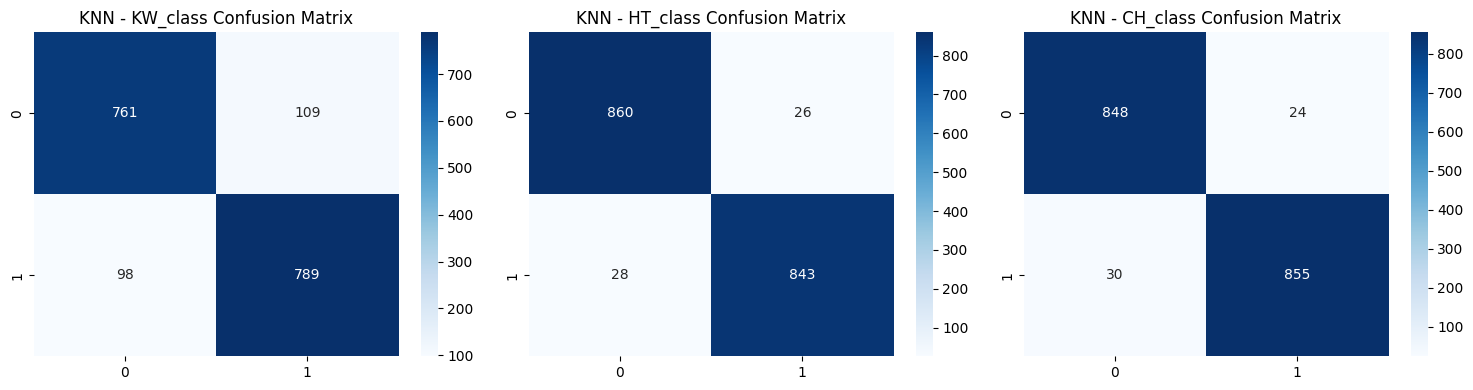

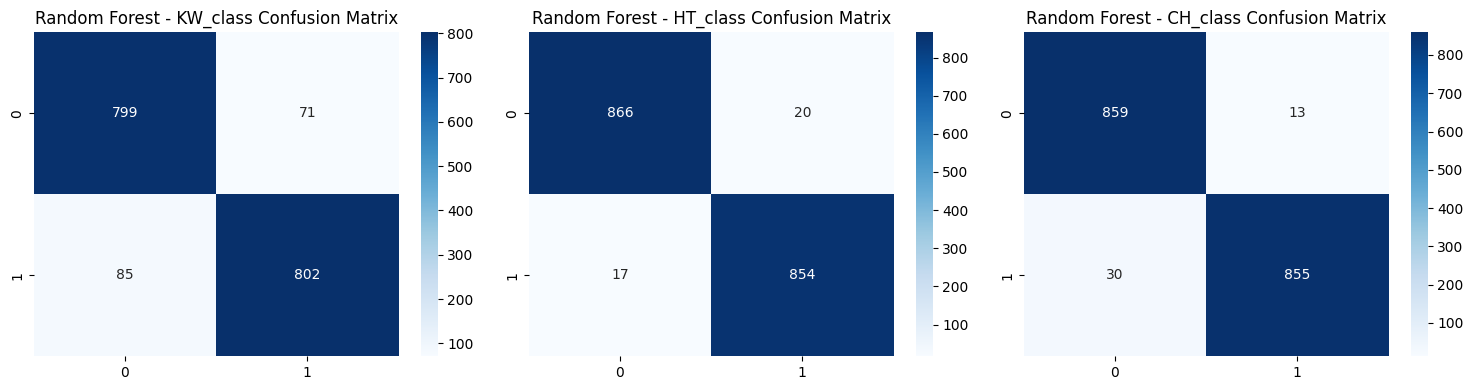

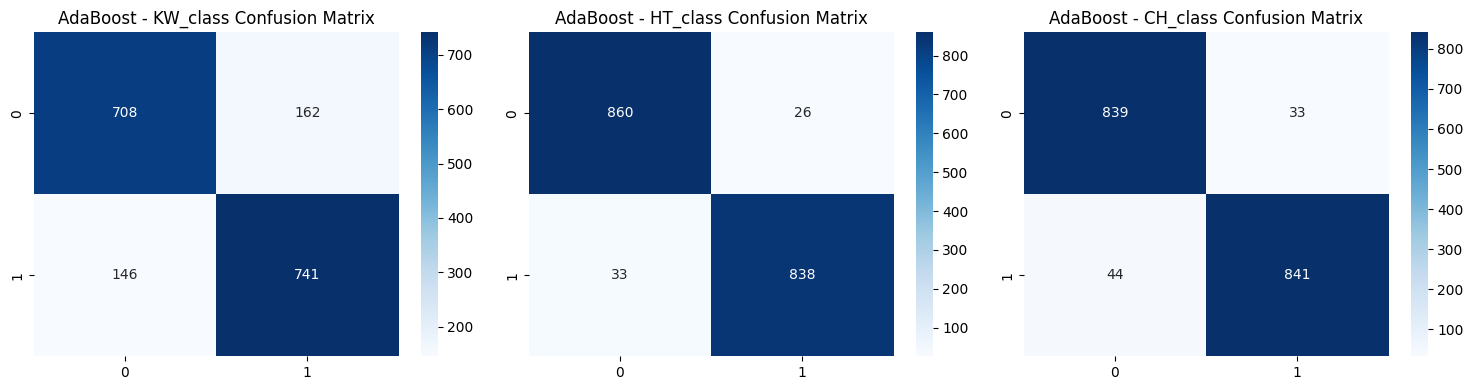

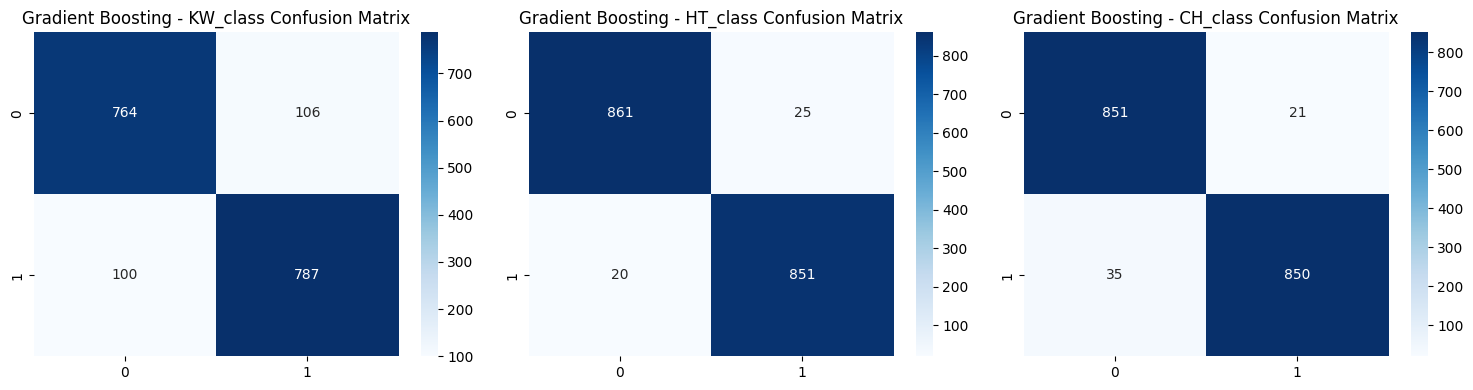

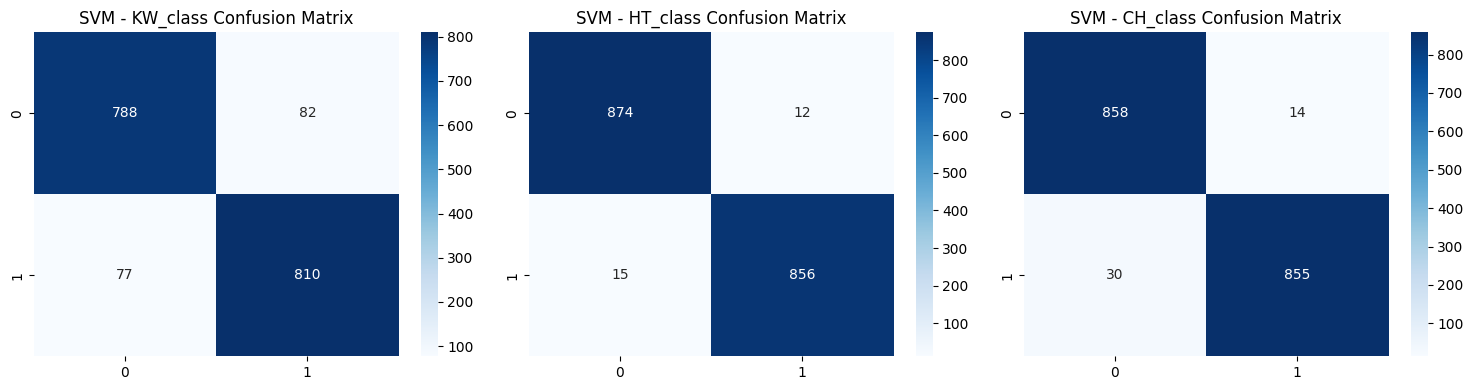

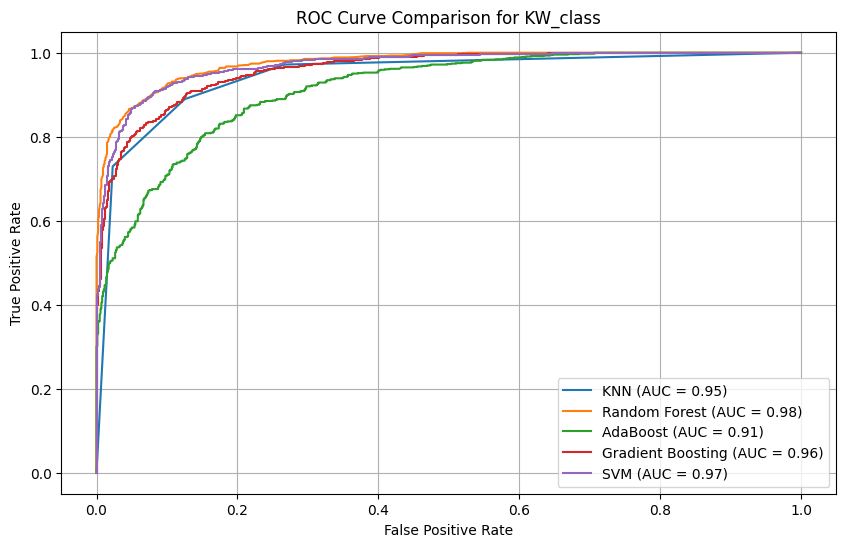

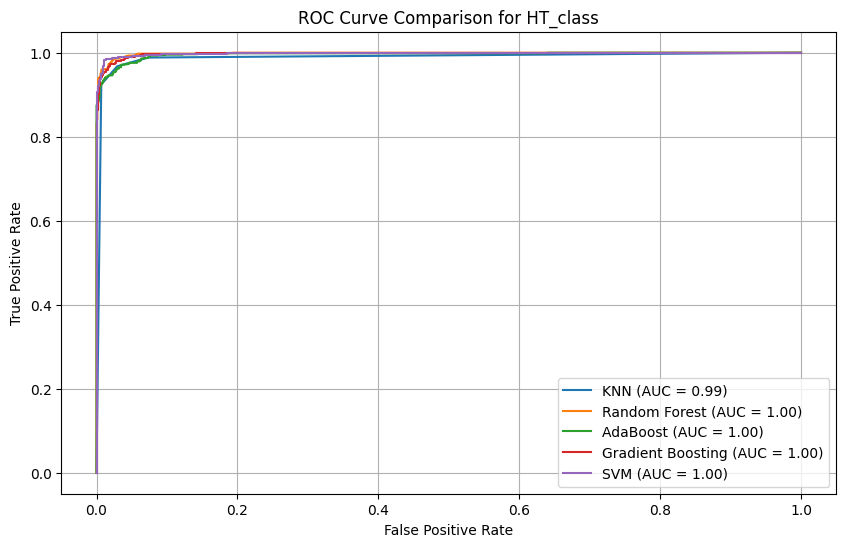

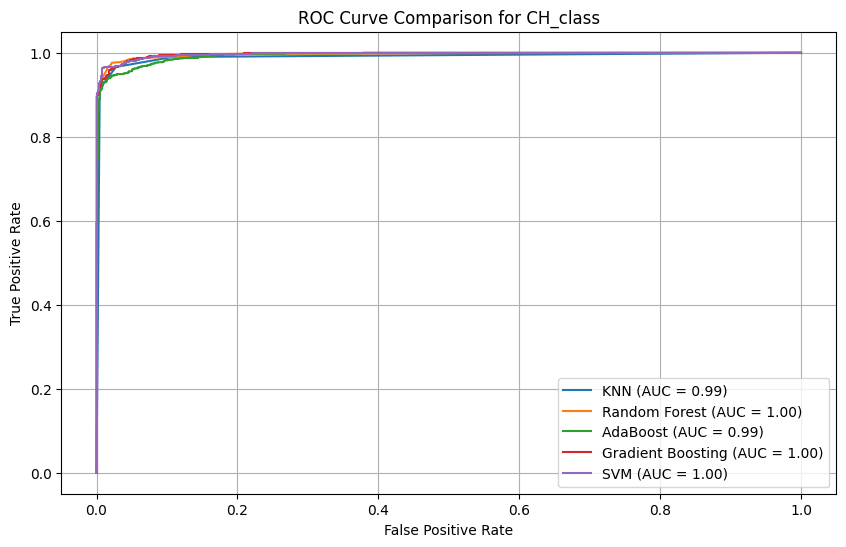

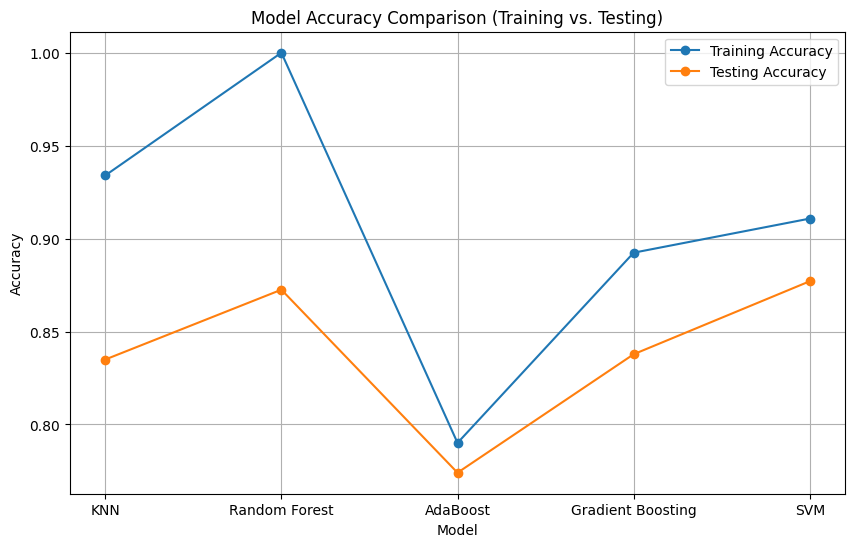

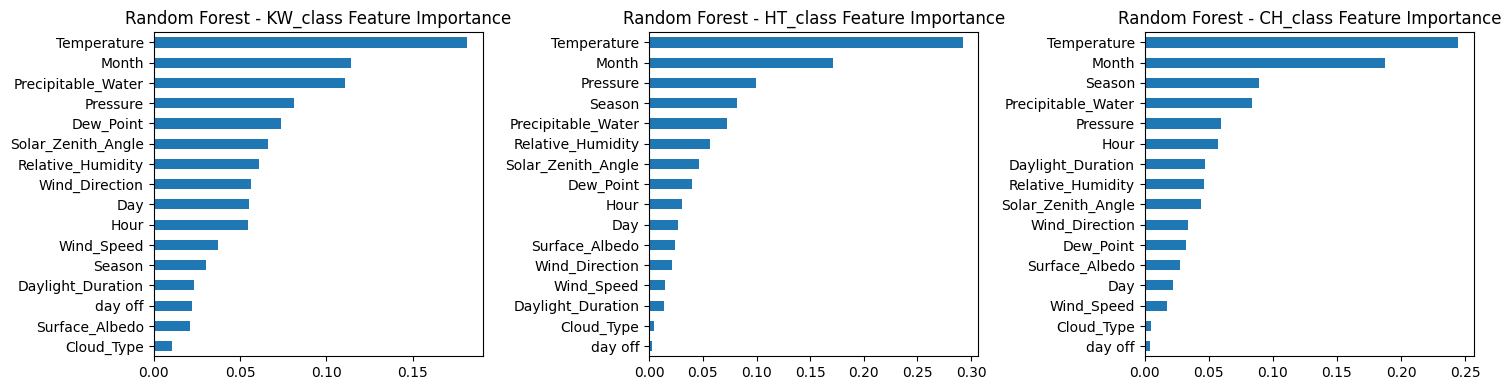

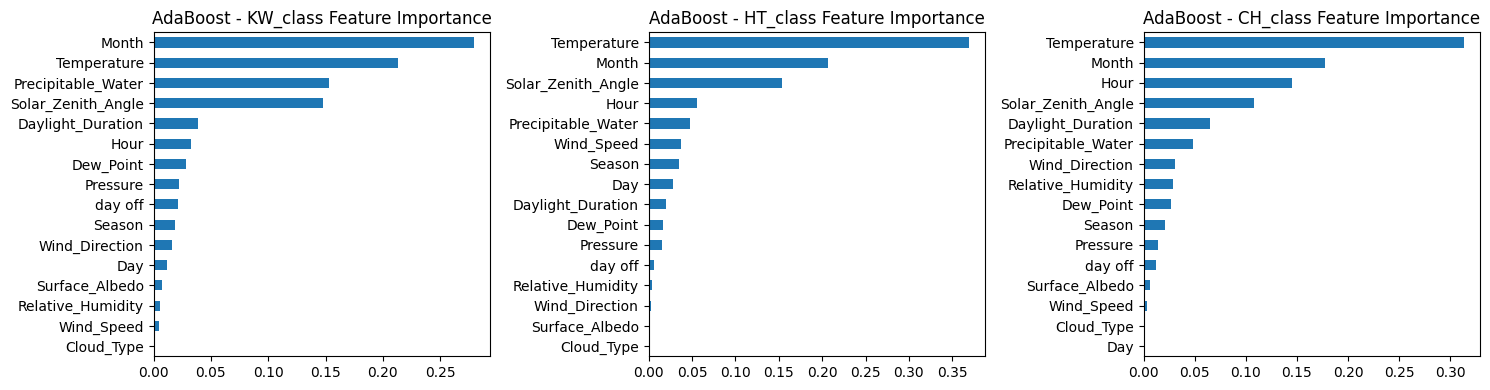

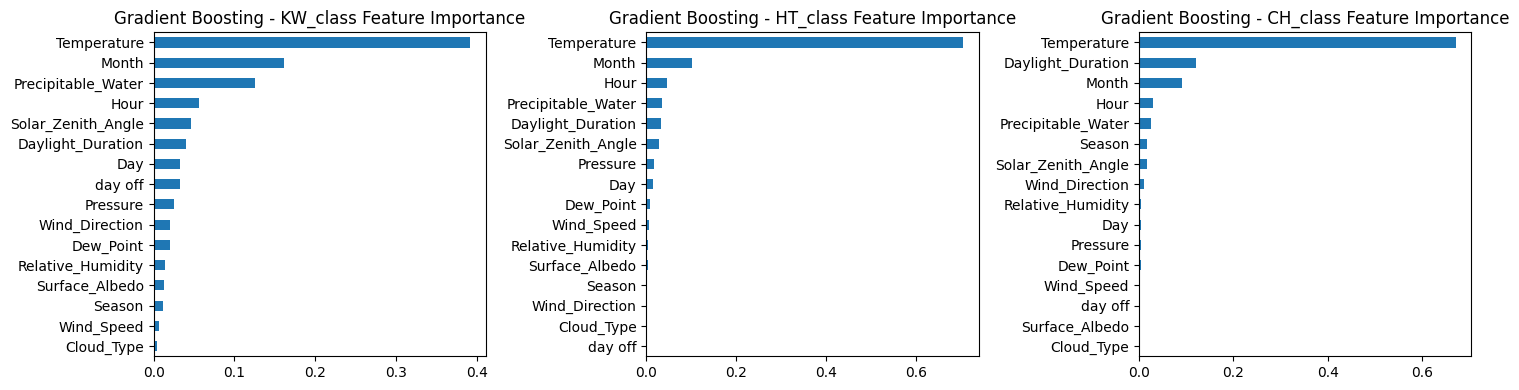

In [6]:
#Model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import UndefinedMetricWarning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Ignore UndefinedMetricWarning warnings
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


# 1. Load and preprocess the dataset
file_path = "/content/drive/MyDrive/CU/Machine Learning: Theory & Hands-On Practice with Python/energy_data.xlsx"
df = pd.read_excel(file_path)

# Define season using month
def assign_season(month):
    if month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3
    else:
        return 4

df['Season'] = df['Month'].apply(assign_season)

# Add sunrise/sunset time for each month
sunrise_sunset = {
    1:  (7.00, 18.00), 2:  (6.75, 18.25), 3:  (6.25, 18.00),
    4:  (6.00, 19.00), 5:  (5.75, 19.25), 6:  (5.50, 19.75),
    7:  (5.50, 19.75), 8:  (5.75, 19.25), 9:  (6.25, 18.00),
    10: (6.50, 17.75), 11: (6.75, 17.50), 12: (7.00, 18.00)
}
df['Sunrise'] = df['Month'].map(lambda x: sunrise_sunset[x][0])
df['Sunset'] = df['Month'].map(lambda x: sunrise_sunset[x][1])
df['Daylight_Duration'] = np.where((df['Hour'] >= df['Sunrise']) & (df['Hour'] < df['Sunset']), 1, 0)
df.drop(columns=['Sunrise', 'Sunset'], inplace=True)

# Define feature types (for reference)
numeric_features = {
    'Year': 'numeric', 'Month': 'numeric', 'Day': 'numeric', 'Hour': 'numeric',
    'KW': 'numeric', 'KWS': 'numeric', 'CHWTON': 'numeric', 'HTmmBTU': 'numeric',
    'Combined_mmBTU': 'numeric', 'Combined_Tons_Carbon': 'numeric',
    'KW_Houses': 'numeric', 'KWlightbulbs': 'numeric', 'KWgalsgas': 'numeric',
    'CHWTON_Houses': 'numeric', 'CHWTONlightbulbs': 'numeric', 'CHWTONgalsgas': 'numeric',
    'HTmmBTU_Houses': 'numeric', 'HTmmBTUlightbulbs': 'numeric', 'HTmmBTUgalsgas': 'numeric',
    'Total_Houses': 'numeric', 'Totallightbulbs': 'numeric', 'Totalgalsgas': 'numeric',
    'GHG': 'numeric', 'Temperature': 'numeric', 'Dew_Point': 'numeric', 'Relative_Humidity': 'numeric',
    'Solar_Zenith_Angle': 'numeric', 'Surface_Albedo': 'numeric', 'Pressure': 'numeric',
    'Precipitable_Water': 'numeric', 'Wind_Speed': 'numeric'
}
categorical_features = {
    'day off': 'categorical', 'DOW': 'categorical', 'Cloud_Type': 'categorical', 'Wind_Direction': 'categorical',
    'Season': 'categorical', 'Daylight_Duration': 'categorical'
}

# Remove redundant features
redundant_features = [
    'KW_Houses', 'KWlightbulbs', 'KWgalsgas',
    'CHWTON_Houses', 'CHWTONlightbulbs', 'CHWTONgalsgas',
    'HTmmBTU_Houses', 'HTmmBTUlightbulbs', 'HTmmBTUgalsgas',
    'Totallightbulbs', 'Totalgalsgas', 'KWS','Combined_mmBTU',
    'Combined_Tons_Carbon','GHG','Year','DOW','Total_Houses'
]
df_clean = df.drop(columns=redundant_features)


# 2. Create binary target variables for each load
# Convert continuous load values into binary high/low classes based on the median
df_clean['KW_class'] = (df_clean['KW'] > df_clean['KW'].median()).astype(int)
df_clean['HT_class'] = (df_clean['HTmmBTU'] > df_clean['HTmmBTU'].median()).astype(int)
df_clean['CH_class'] = (df_clean['CHWTON'] > df_clean['CHWTON'].median()).astype(int)


# 3. Define features and multi-output targets
# Remove continuous load and target columns to avoid data leakage
X = df_clean.drop(columns=['KW', 'HTmmBTU', 'CHWTON', 'KW_class', 'HT_class', 'CH_class'])
y = df_clean[['KW_class', 'HT_class', 'CH_class']]


# 4. Standardize features (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# 5. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


# 6. Define models and perform hyperparameter tuning using GridSearchCV
models = {
    "KNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42)
}

param_grids = {
    "KNN": {"n_neighbors": [3, 5, 7]},
    "Random Forest": {"n_estimators": [50, 100, 200]},
    "AdaBoost": {"n_estimators": [50, 100, 200]},
    "Gradient Boosting": {"n_estimators": [50, 100, 200]},
    "SVM": {"C": [0.1, 1, 10]}
}

best_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=3, scoring='accuracy', n_jobs=-1)
    multi_target_model = MultiOutputClassifier(grid_search)
    multi_target_model.fit(X_train, y_train)
    best_models[name] = multi_target_model


# 7. Evaluate models: Compute training/testing accuracy, classification report, confusion matrices, and ROC curves
accuracy_scores = {}
train_accuracy_scores = {}
conf_matrices = {}
roc_curves = {}

for name, model in best_models.items():
    # Predict test set
    y_pred_test = model.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    accuracy_scores[name] = test_acc

    # Predict training set
    y_pred_train = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_pred_train)
    train_accuracy_scores[name] = train_acc

    print(f"{name} Testing Accuracy: {test_acc:.4f}")
    # Use zero_division=0 to handle undefined metrics
    print(classification_report(y_test, y_pred_test, zero_division=0))

    # Compute confusion matrices for each target variable
    conf_matrices[name] = {}
    for i, col in enumerate(y_test.columns):
        cm = confusion_matrix(y_test[col], y_pred_test[:, i])
        conf_matrices[name][col] = cm

    # Compute ROC curves for each target variable
    y_prob = model.predict_proba(X_test)  # List: probability predictions for each target
    roc_curves[name] = {}
    for i, col in enumerate(y_test.columns):
        # Extract predicted probabilities for the positive class (label 1)
        fpr, tpr, _ = roc_curve(y_test[col], y_prob[i][:, 1])
        roc_auc = auc(fpr, tpr)
        roc_curves[name][col] = (fpr, tpr, roc_auc)


# 8. Plot confusion matrices for each model and each target variable
for name, cms in conf_matrices.items():
    fig, axes = plt.subplots(1, len(cms), figsize=(5 * len(cms), 4))
    if len(cms) == 1:
        axes = [axes]
    for ax, (col, cm) in zip(axes, cms.items()):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(f"{name} - {col} Confusion Matrix")
    plt.tight_layout()
    plt.show()


# 9. Plot ROC Curves for each target variable
# For each target (KW_class, HT_class, CH_class), plot ROC curves with all models
target_names = ['KW_class', 'HT_class', 'CH_class']
for col in target_names:
    plt.figure(figsize=(10, 6))
    for name, model in best_models.items():
        # Find the index of the target variable in y_test (assuming the order is the same as y_test.columns)
        i = list(y_test.columns).index(col)
        y_prob = model.predict_proba(X_test)[i]
        fpr, tpr, _ = roc_curve(y_test[col], y_prob[:, 1])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve Comparison for {col}")
    plt.legend()
    plt.grid()
    plt.show()


# 10. Plot accuracy comparison (training vs. testing) using a line plot
models_list = list(accuracy_scores.keys())
train_acc_values = [train_accuracy_scores[m] for m in models_list]
test_acc_values = [accuracy_scores[m] for m in models_list]

plt.figure(figsize=(10, 6))
plt.plot(models_list, train_acc_values, marker='o', linestyle='-', label='Training Accuracy')
plt.plot(models_list, test_acc_values, marker='o', linestyle='-', label='Testing Accuracy')
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison (Training vs. Testing)")
plt.legend()
plt.grid()
plt.show()


# 11. Feature importance for tree-based models (Random Forest, AdaBoost, Gradient Boosting)
tree_models = ["Random Forest", "AdaBoost", "Gradient Boosting"]
for name in tree_models:
    # Create a dictionary to store feature importance for each target variable
    feature_importances = {}
    for i, target in enumerate(y_test.columns):
        # best_models[name].estimators_[i] is the GridSearchCV object for the target variable
        estimator = best_models[name].estimators_[i].best_estimator_
        feature_importances[target] = estimator.feature_importances_

    # Plot feature importance for each target variable
    fig, axes = plt.subplots(1, len(y_test.columns), figsize=(5 * len(y_test.columns), 4))
    if len(y_test.columns) == 1:
        axes = [axes]
    for ax, target in zip(axes, y_test.columns):
        imp = feature_importances[target]
        feat_imp = pd.Series(imp, index=X.columns).sort_values()
        feat_imp.plot(kind='barh', ax=ax)
        ax.set_title(f"{name} - {target} Feature Importance")
    plt.tight_layout()
    plt.show()
